TKO_3120 Machine Learning and Pattern Recognition

Image recognition exercise



This is the template for the image recognition exercise. <Br>
Some **general instructions**:
 - write a clear *report*, understandable for an unspecialized reader: define shortly the concepts and explain the phases you use
    - use the Markdown feature of the notebook for larger explanations
 - return your output as a working Jupyter notebook
 - name your file as MLPR25_exercise_surname_firstname.jpynb
 - write easily readable code with comments     
     - if you exploit some code from web, provide a reference
     - avoid redundant code! Exploit the relevent parts and modify the code for your purposes to produce only what you need
 - it is ok to discuss with a friend about the assignment. But it is not ok to copy someone's work. Everyone should submit their own implementation

**Deadline 14th of March at 16:00**
- No extension granted, unless you have an extremely justified reason. In such case, ask for extension well in advance!
- Start now, do not leave it to the last minute. This exercise will need some labour!
- If you encounter problems
    - Google first
    - ask for help at the discussion area at Moodle
    - email tmvaha@utu.fi

**Grading**

The exercise covers a part of the grading in this course. The course exam has 5 questions, 6 points of each. Exercise gives 6 points, i.e. the total score is 36 points. Two extra points can be acquired by completing the bonus task. <br>

From the template below, you can see how many exercise points can be acquired from each task. Exam points are given according to the table below: <br>
<br>
9-10 exercise points: 1 point <br>
11-12 exercise points: 2 points <br>
13-14 exercise points: 3 points <br>
15-16 exercise points: 4 points <br>
17-18 exercise points: 5 points <br>
19-20 exercise points: 6 points <br>
<br>
To pass the exercise, you need at least 8 exercise points, distributed somewhat evenly into tasks (you can't just implement Introduction, Data preparation and Feature extraction and leave the left undone!) <br>       

## Introduction

Write an introductory chapter for your report **(1 p)**
<br>E.g.
- What is the purpose of this task?
- What kind of data were used? Where did it originate?
- Which methods did you use?

Three sets of image URLs provided as text files (in Moodle): grass, sand and stairs

Images are with different resolution and dimensions
Images have been gathered from https://unsplash.com/

**Purpose of the Task**

The purpose of this exercise is to develop and evaluate machine learning models for image classification. The goal is to determine which classifier performs best in distinguishing between different image categories based on extracted features. We achieve this by training multiple models, tuning their hyperparameters, and assessing their generalization performance using cross-validation techniques.

**Dataset Description**

The dataset consists of **185 images**, from which we **extracted 10  features**. These features capture key properties of the images, enabling classification without directly using pixel values. The dataset contains images of different classes, including **grass, sand, and stairs**, making it a multi-class classification problem. The images were preprocessed to grayscale and quantized into 8 levels to enhance feature extraction.

**Methods Used**

To build and evaluate classifiers, the following machine learning methods were applied:

*   **Feature Extraction**: In this study, we extract and analyze various texture and color features to classify image data effectively. Texture-based features were extracted using **Gray-Level Co-occurrence Matrix (GLCM)** technique.
*   **Classification Models**: Three classifiers were implemented:
    *   **Ridge Classifier**
    *   **Random Forest**
    *   **Multi-Layer Perceptron (MLP)**
*   **Hyperparameter Tuning**: **GridSearchCV** with **5-fold Stratified Cross-Validation** was used to optimize hyperparameters for each classifier.
*   **Performance Estimation**: **Nested Cross-Validation** was applied, using **4-fold Stratified K-Fold** in the inner loop for hyperparameter tuning and **5-fold Stratified K-Fold** in the outer loop to estimate model performance.
*   **Evaluation Metrics**: The models were evaluated using **accuracy scores** and **confusion matrices** to assess classification performance. For the **Random Forest model**, feature importance was analyzed to understand the contribution of different features.

**Structure of the Report**

The report presents the methodology, experimental results, and a discussion on model performance. We first describe the classification models and cross-validation techniques. Then, we present the results of hyperparameter tuning and nested cross-validation. Finally, we analyze feature importance, discuss model performance, and conclude with key findings.

## Data preparation

Perform preparations for the data **(3 p)**
- import all the packages needed for this notebook in one cell
- read the URL:s from the text files and import the images
- crop and/or resize the images into same size
- for GLCM and GLRLM, change the images into grayscale and reduce the quantization level, e.g. to 8 levels

### Import all necessary packages

In [ ]:
# Image processing
import cv2
import numpy as np
import imageio.v2 as imageio
from PIL import Image
from skimage.transform import resize
from skimage.color import rgb2gray
from skimage.feature import graycomatrix, graycoprops

# Data handling and visualization
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd

# Machine Learning
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score

### Read the URLs from the text files and load images

In [ ]:
# Function to load images from URLs
def load_images_from_urls(url_list):
    images = []
    for url in url_list:
        img = imageio.imread(url)
        images.append(img)
    return images

In [ ]:
# Collect URLs from text files
url_grass = np.loadtxt('grass.txt', dtype='U150')
url_sand = np.loadtxt('sand.txt', dtype='U150')
url_stairs = np.loadtxt('stairs.txt', dtype='U150')

# Load the images for each class
grass_images = load_images_from_urls(url_grass)
sand_images = load_images_from_urls(url_sand)
stairs_images = load_images_from_urls(url_stairs)

# Print the number of images loaded for each class
print(f"Grass images loaded: {len(grass_images)}")
print(f"Sand images loaded: {len(sand_images)}")
print(f"Stairs images loaded: {len(stairs_images)}")

Grass images loaded: 62
Sand images loaded: 61
Stairs images loaded: 62


**Plot some images**

In [ ]:
# Function to plot images
def plot_images(images, titles, figsize):
    plt.figure(figsize=figsize)
    for i, (img, title) in enumerate(zip(images, titles), 1):
        plt.subplot(1, len(images), i)
        plt.imshow(img)
        plt.title(title)
    plt.show()

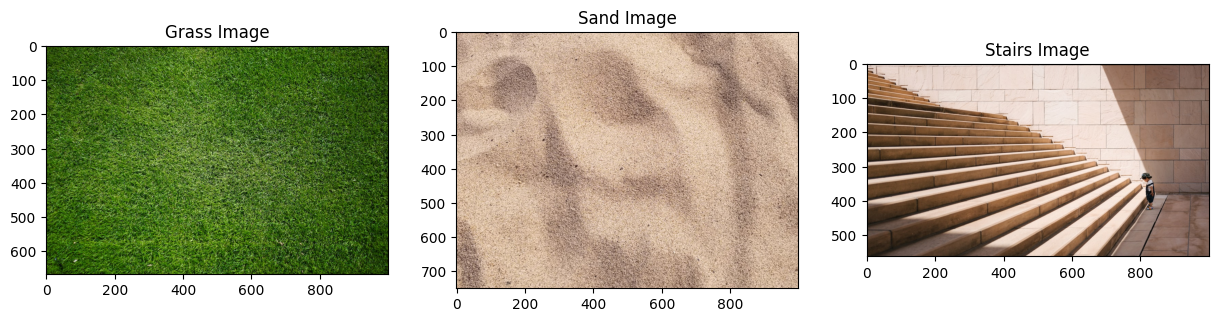

In [ ]:
# Define images and titles
images = [grass_images[0], sand_images[0], stairs_images[0]]
titles = ['Grass Image', 'Sand Image', 'Stairs Image']

plot_images(images, titles, figsize=(15, 5))

### Resize the images into same size (512, 512)

- Resizing scales an image to a new size while preserving its structure, ensuring consistency in input dimensions for machine learning models. Unlike cropping, which removes parts of the image, resizing retains all details, preventing loss of important features.

- A **512x512** resolution balances detail retention and computational efficiency. It is large enough to preserve important texture and structural features while being manageable for processing and memory.

In [ ]:
# Function to resize images to the target size
def resize_images(images, target_size):
    resized_images = []
    for img in images:
        resized_img = resize(img, target_size, mode='reflect', anti_aliasing=True)
        resized_images.append(resized_img)
    return resized_images

In [ ]:
# Desired image size
target_size = (512, 512)

grass_resized = resize_images(grass_images, target_size)
sand_resized = resize_images(sand_images, target_size)
stairs_resized = resize_images(stairs_images, target_size)

# Print the size of the resized images
print(f"Resized Grass image shape: {grass_resized[0].shape}")
print(f"Resized Sand image shape: {sand_resized[0].shape}")
print(f"Resized Stairs image shape: {stairs_resized[0].shape}")


Resized Grass image shape: (512, 512, 3)
Resized Sand image shape: (512, 512, 3)
Resized Stairs image shape: (512, 512, 3)


**Plot some resized images**

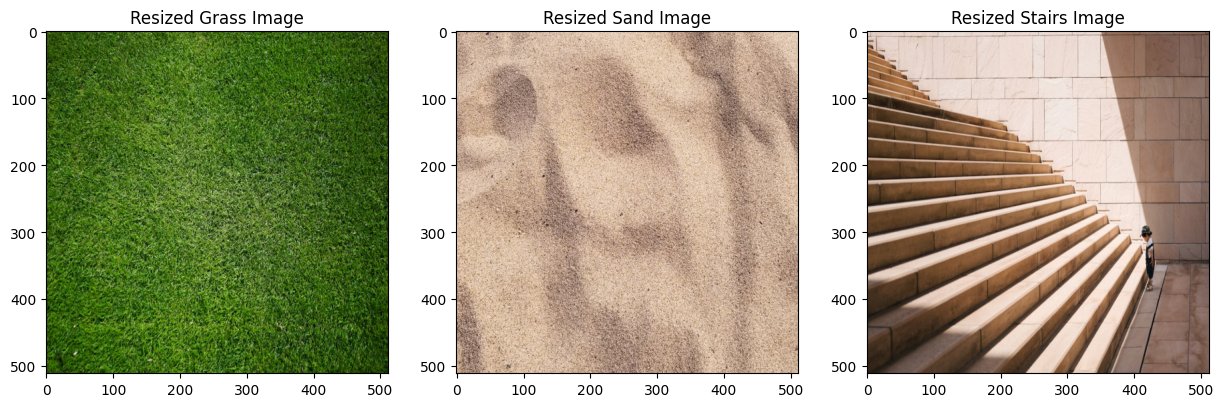

In [ ]:
# Define images and titles
images = [grass_resized[0], sand_resized[0], stairs_resized[0]]
titles = ['Resized Grass Image', 'Resized Sand Image', 'Resized Stairs Image']

# Plot images
plot_images(images, titles, figsize=(15, 5))

### Change the Images into Grayscale and Reduce the Quantization Level to 8 Levels

- **Grayscale Conversion:** Simplifies the image by removing the color information while preserving intensity patterns, which is important for tasks like texture recognition or object detection that are based on structural features rather than color.

- **Quantization:** Reduces the pixel value range from 256 levels (8-bit) to a smaller range, which can be helpful for reducing the complexity of the model and making it more robust to minor variations in pixel values.

In [ ]:
# Function to convert images to grayscale
def convert_to_grayscale(images):
    grayscale_images = [rgb2gray(img) for img in images]
    return grayscale_images

In [ ]:
# Convert images for each class to grayscale
grass_grayscale = convert_to_grayscale(grass_resized)
sand_grayscale = convert_to_grayscale(sand_resized)
stairs_grayscale = convert_to_grayscale(stairs_resized)

# Print the shape and data type to verify
print(f"Grayscale Grass image shape: {grass_grayscale[0].shape}")
print(f"Grayscale Sand image shape: {sand_grayscale[0].shape}")
print(f"Grayscale Stairs image shape: {stairs_grayscale[0].shape}")


Grayscale Grass image shape: (512, 512)
Grayscale Sand image shape: (512, 512)
Grayscale Stairs image shape: (512, 512)


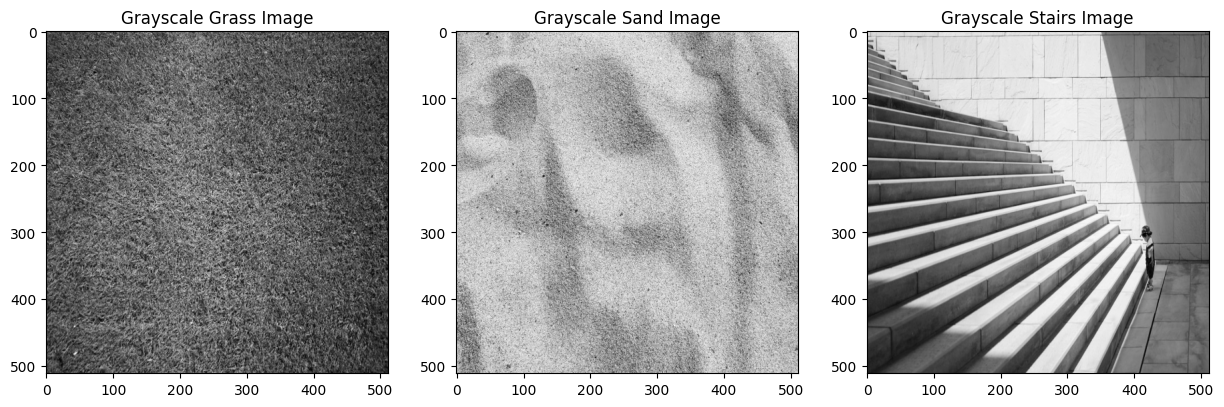

In [ ]:
# Display the grayscale images for each class
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(grass_grayscale[0], cmap='gray')
plt.title('Grayscale Grass Image')

plt.subplot(1, 3, 2)
plt.imshow(sand_grayscale[0], cmap='gray')
plt.title('Grayscale Sand Image')

plt.subplot(1, 3, 3)
plt.imshow(stairs_grayscale[0], cmap='gray')
plt.title('Grayscale Stairs Image')

plt.show()

#### Quantization


In [ ]:
def quantize_grayscale_images(grayscale_images, quantization_levels=8):
    quantized_images = []
    for img in grayscale_images:
        # Scale the pixel values to discrete levels
        quantized_img = np.floor(img * quantization_levels).astype(np.uint8)

        # Ensure values stay within the valid range
        quantized_img = np.clip(quantized_img, 0, quantization_levels - 1)

        quantized_images.append(quantized_img)

    return quantized_images

In [ ]:

# Apply quantization to grayscale images
grass_quantized = quantize_grayscale_images(grass_grayscale)
sand_quantized = quantize_grayscale_images(sand_grayscale)
stairs_quantized = quantize_grayscale_images(stairs_grayscale)

# Print the shape and data type to verify
print(f"Quantized Grass image shape: {grass_quantized[0].shape}, dtype: {grass_quantized[0].dtype}")
print(f"Quantized Sand image shape: {sand_quantized[0].shape}, dtype: {sand_quantized[0].dtype}")
print(f"Quantized Stairs image shape: {stairs_quantized[0].shape}, dtype: {stairs_quantized[0].dtype}")


Quantized Grass image shape: (512, 512), dtype: uint8
Quantized Sand image shape: (512, 512), dtype: uint8
Quantized Stairs image shape: (512, 512), dtype: uint8


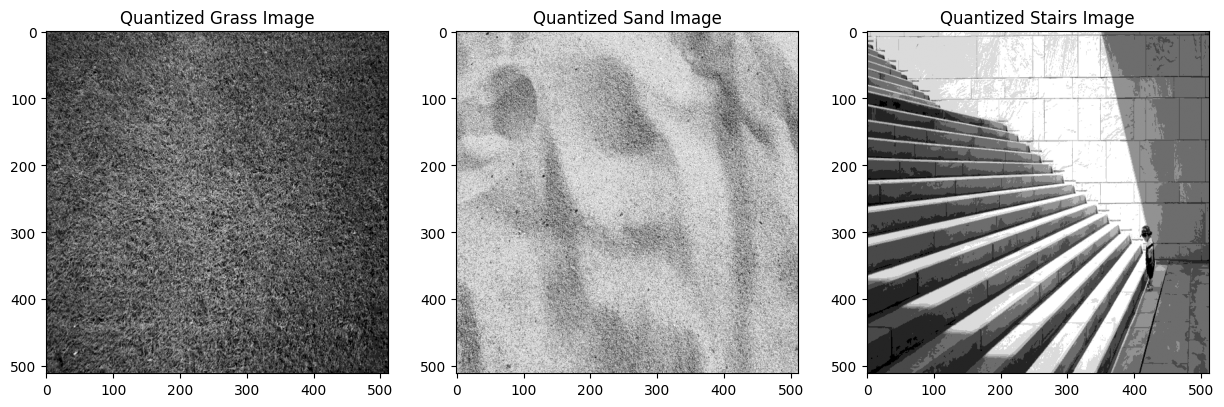

In [ ]:
# Display the quantized grayscale images for each class
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(grass_quantized[0], cmap='gray')
plt.title('Quantized Grass Image')

plt.subplot(1, 3, 2)
plt.imshow(sand_quantized[0], cmap='gray')
plt.title('Quantized Sand Image')

plt.subplot(1, 3, 3)
plt.imshow(stairs_quantized[0], cmap='gray')
plt.title('Quantized Stairs Image')

plt.show()

## Feature extraction

### First order texture measures (6 features)


1. The mean of each RGB channel (Red, Green, and Blue) helps describe the average color intensity in an image.
2. The variance measures how much the color values fluctuate, indicating color diversity or consistency.

- Calculate the below mentioned color features for each image **(1 p)**
    - Mean for each RGB color channel
    - Variance for each RGB color channel

In [ ]:
# Function to compute mean and variance for each RGB channel
def compute_color_features(images):
    features = []

    for img in images:
        # Compute mean and variance for R, G, and B channels
        mean_r, mean_g, mean_b = np.mean(img, axis=(0, 1))  # Mean along height & width
        var_r, var_g, var_b = np.var(img, axis=(0, 1))      # Variance along height & width

        # Store as feature vector [Mean_R, Mean_G, Mean_B, Var_R, Var_G, Var_B]
        features.append([mean_r, mean_g, mean_b, var_r, var_g, var_b])

    return np.array(features)


In [ ]:
# Compute features for each class
grass_color_features = compute_color_features(grass_resized)
sand_color_features = compute_color_features(sand_resized)
stairs_color_features = compute_color_features(stairs_resized)

# Print example results
print("Grass - Mean & Variance (R, G, B):", grass_color_features[0])
print("Sand  - Mean & Variance (R, G, B):", sand_color_features[0])
print("Stairs - Mean & Variance (R, G, B):", stairs_color_features[0])

Grass - Mean & Variance (R, G, B): [0.25613001 0.40329103 0.10576573 0.01398264 0.01637809 0.00859195]
Sand  - Mean & Variance (R, G, B): [0.77577763 0.66255406 0.57609808 0.01231258 0.01285283 0.01147374]
Stairs - Mean & Variance (R, G, B): [0.64130966 0.53675073 0.46959699 0.05931303 0.06528702 0.07452213]


### Second order texture measures (4 features)

- Gray-Level-Co-Occurrence (GLCM) features (4 features) **(2 p)**
    - For each image
        - calculate the GLC matrix
        - calculate the "correlation" feature using the GLC matrix that you acquired
            - in horizontal and vertical directions for two reference pixel distances (you can choose the distances)
        - explain your choise for the distances<br>

Gather your features into an input array X, and the image classes into an output array y. Standardize the feature values in X.

In [ ]:
# Function to compute GLCM correlation feature
def compute_glcm_features(images, distances=[1, 3], angles=[0, np.pi/2]):
    features = []

    for img in images:
        # Compute GLCM matrix
        glcm = graycomatrix(img, distances=distances, angles=angles, levels=8, symmetric=True, normed=True)

        # Compute correlation feature for each distance & angle
        corr_1_0 = graycoprops(glcm, 'correlation')[0, 0]  # Distance 1, Angle 0° (horizontal)
        corr_1_90 = graycoprops(glcm, 'correlation')[0, 1] # Distance 1, Angle 90° (vertical)
        corr_3_0 = graycoprops(glcm, 'correlation')[1, 0]  # Distance 3, Angle 0°
        corr_3_90 = graycoprops(glcm, 'correlation')[1, 1] # Distance 3, Angle 90°

        # Store as a feature vector
        features.append([corr_1_0, corr_1_90, corr_3_0, corr_3_90])

    return np.array(features)

In [ ]:
# Compute GLCM features for each class
grass_glcm_features = compute_glcm_features(grass_quantized)
sand_glcm_features = compute_glcm_features(sand_quantized)
stairs_glcm_features = compute_glcm_features(stairs_quantized)

# Print example results
print("Grass - GLCM Features:", grass_glcm_features[0])
print("Sand  - GLCM Features:", sand_glcm_features[0])
print("Stairs - GLCM Features:", stairs_glcm_features[0])

Grass - GLCM Features: [0.4812013  0.5713414  0.23750268 0.22027244]
Sand  - GLCM Features: [0.52556362 0.54512773 0.41691356 0.42186469]
Stairs - GLCM Features: [0.97688665 0.96165508 0.93214192 0.86219302]


#### Justification for Choosing Distances 1 and 3 in GLCM

The choice of distances `[1, 3]` in the function `compute_glcm_features` is based on capturing both local and global texture information in the image. Here's why:

1. **Distance of 1**:
   - A distance of `1` corresponds to the nearest neighboring pixels in the image. This is useful for capturing fine, local texture details in the image. It focuses on pixel relationships that are closely connected, such as edges, fine patterns, or small variations that occur within the immediate vicinity of each pixel.
   - This distance is commonly used in texture analysis to assess the minute texture changes at a very localized level.

2. **Distance of 3**:
   - A distance of `3` corresponds to pixel pairs that are spaced further apart. This distance helps to capture coarser, more global texture features. It can reveal larger patterns or structures within the image that might not be visible at smaller distances, such as broader shapes or repetitive structures.
   - Using this distance allows the GLCM to reflect texture properties that span a larger region of the image, providing more information about the global texture characteristics.

**Practical Considerations**:
   - For low-level quantization (such as 8 levels), smaller distances (e.g., 1 or 3) are more suitable because they focus on local and medium-range spatial relationships that are more likely to be informative and non-sparse.
   - If the image were quantized to higher levels (e.g., 16 or 256), using larger distances could potentially be more effective, as finer gray level differences would allow for better capture of global textures across the image.


### Gather the features into an input array X, and the image classes into an output array y

In [ ]:
# Define feature names for readability
feature_names = [
    "Mean_R", "Mean_G", "Mean_B", "Var_R", "Var_G", "Var_B",
    "GLCM_Corr_1_0", "GLCM_Corr_1_90", "GLCM_Corr_3_0", "GLCM_Corr_3_90"
]

# Stack both color and GLCM features
X = np.hstack([
    np.vstack([grass_color_features, sand_color_features, stairs_color_features]),  # Color features
    np.vstack([grass_glcm_features, sand_glcm_features, stairs_glcm_features])      # GLCM features
])

# Convert X to DataFrame
X_df = pd.DataFrame(X, columns=feature_names)

# Gather corresponding labels (0 = Grass, 1 = Sand, 2 = Stairs)
class_names = ['Grass', 'Sand', 'Stairs']
y = np.array([class_names[0]] * len(grass_color_features) +
             [class_names[1]] * len(sand_color_features) +
             [class_names[2]] * len(stairs_color_features))

print("X_df shape:", X_df.shape)
print("y shape:", y.shape)

# Print first few rows of X_df to check
X_df.head()

X_df shape: (185, 10)
y shape: (185,)


Mean_R    Mean_G    Mean_B     Var_R     Var_G     Var_B  GLCM_Corr_1_0  \
0  0.256130  0.403291  0.105766  0.013983  0.016378  0.008592       0.481201   
1  0.473838  0.551064  0.488036  0.063829  0.050615  0.083857       0.961859   
2  0.107916  0.352104  0.065584  0.007653  0.043563  0.006051       0.798111   
3  0.398552  0.463686  0.088947  0.016201  0.018554  0.008339       0.772013   
4  0.426327  0.597364  0.153262  0.033051  0.023546  0.022652       0.927729   

   GLCM_Corr_1_90  GLCM_Corr_3_0  GLCM_Corr_3_90  
0        0.571341       0.237503        0.220272  
1        0.960793       0.937280        0.923509  
2        0.813309       0.474110        0.512543  
3        0.866693       0.492020        0.614355  
4        0.972085       0.812663        0.914602

### Standardized the features


In [ ]:
# Standardize the feature values in X
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_df)

# Convert the scaled data back to a DataFrame for readability (optional)
X_scaled_df = pd.DataFrame(X_scaled, columns=feature_names)

# Print first few rows of the scaled DataFrame
X_scaled_df.head()

Mean_R    Mean_G    Mean_B     Var_R     Var_G     Var_B  GLCM_Corr_1_0  \
0 -1.242593 -0.598552 -1.509998 -0.905752 -0.770297 -0.818700      -3.108877   
1 -0.096596  0.339087  0.481141  0.972809  0.670455  1.183782       0.518235   
2 -2.022779 -0.923341 -1.719294 -1.144310  0.373694 -0.886293      -0.717433   
3 -0.492896 -0.215337 -1.597602 -0.822168 -0.678728 -0.825423      -0.914368   
4 -0.346688  0.632868 -1.262603 -0.187121 -0.468661 -0.444632       0.260687   

   GLCM_Corr_1_90  GLCM_Corr_3_0  GLCM_Corr_3_90  
0       -2.724371      -3.015755       -2.946303  
1        0.534330       0.704654        0.724599  
2       -0.699724      -1.757817       -1.420646  
3       -0.253041      -1.662598       -0.889188  
4        0.628817       0.042120        0.678106

In [ ]:
# Add class label to the scaled data frame
X_scaled_df['class'] = y

# Print first few rows of the final DataFrame
X_scaled_df.head()

Mean_R    Mean_G    Mean_B     Var_R     Var_G     Var_B  GLCM_Corr_1_0  \
0 -1.242593 -0.598552 -1.509998 -0.905752 -0.770297 -0.818700      -3.108877   
1 -0.096596  0.339087  0.481141  0.972809  0.670455  1.183782       0.518235   
2 -2.022779 -0.923341 -1.719294 -1.144310  0.373694 -0.886293      -0.717433   
3 -0.492896 -0.215337 -1.597602 -0.822168 -0.678728 -0.825423      -0.914368   
4 -0.346688  0.632868 -1.262603 -0.187121 -0.468661 -0.444632       0.260687   

   GLCM_Corr_1_90  GLCM_Corr_3_0  GLCM_Corr_3_90  class  
0       -2.724371      -3.015755       -2.946303  Grass  
1        0.534330       0.704654        0.724599  Grass  
2       -0.699724      -1.757817       -1.420646  Grass  
3       -0.253041      -1.662598       -0.889188  Grass  
4        0.628817       0.042120        0.678106  Grass

## Feature relationships

Make illustrations of the feature relationships, and discuss the results

### Pairplot

- Pairplot **(1 p)**
    - Which feature pairs possess roughly linear dependence?

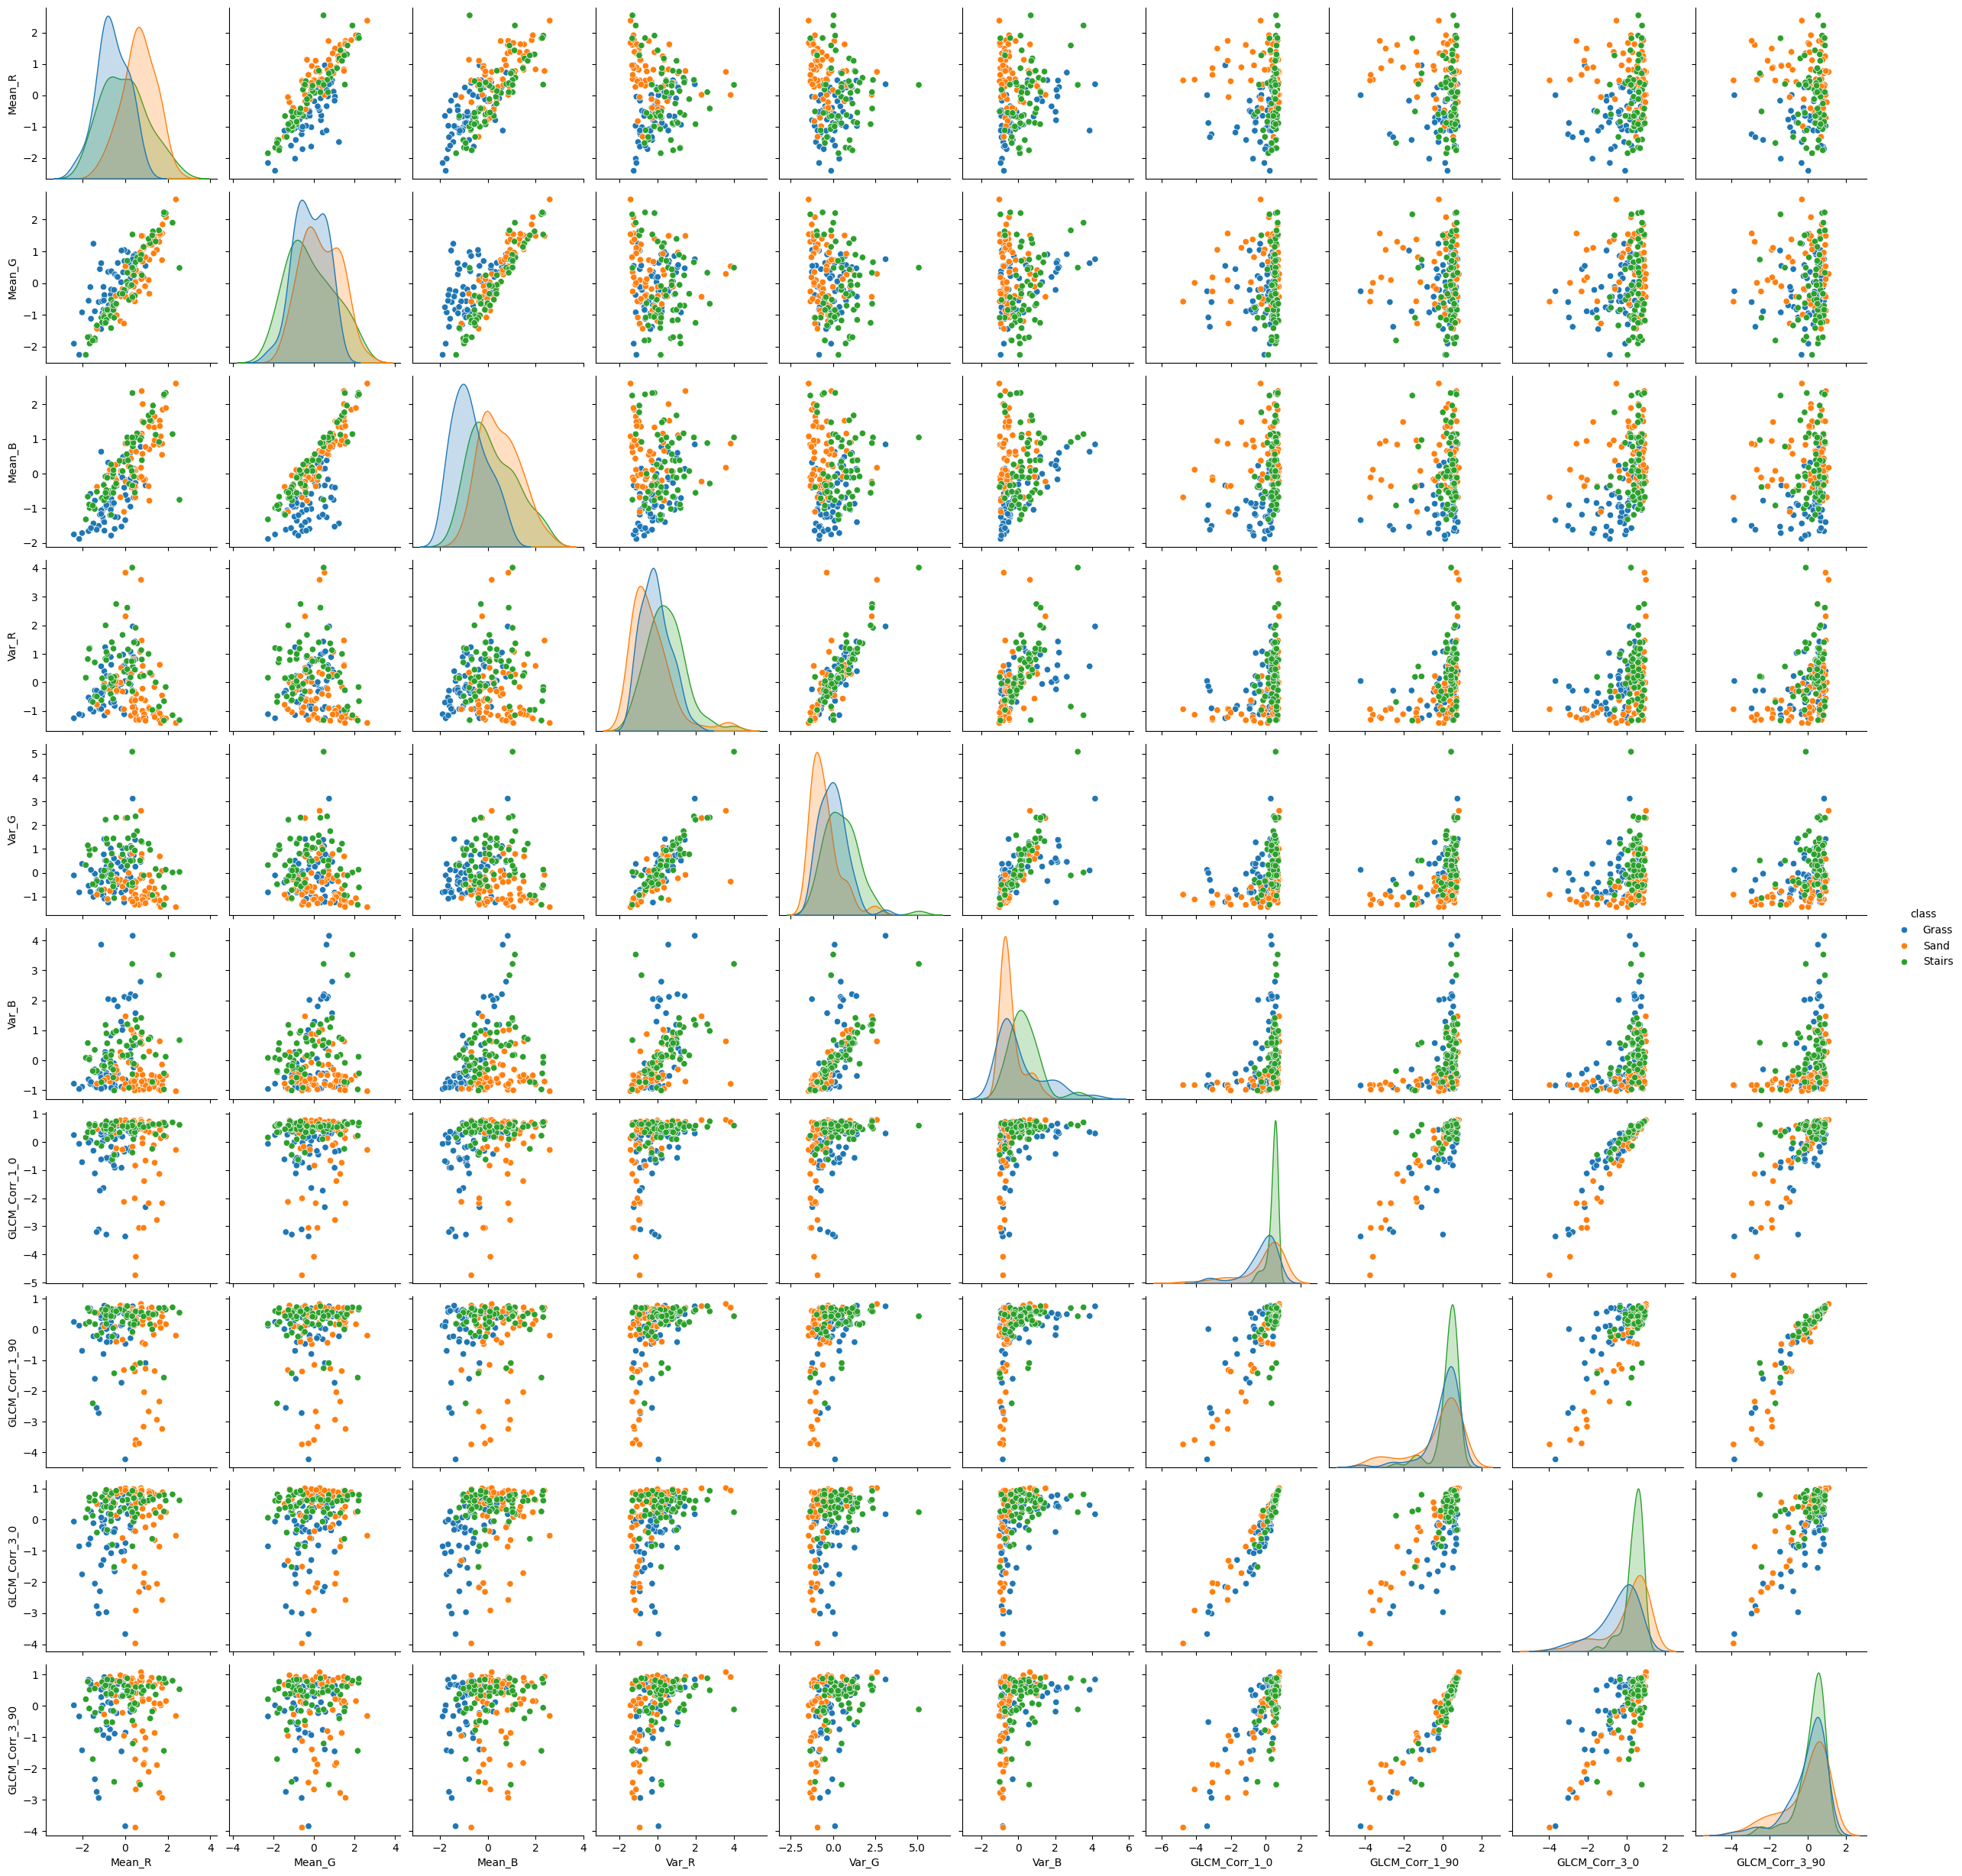

In [ ]:
# Plot the pairplot
sns.pairplot(X_scaled_df, hue='class')

# Show the plot
plt.show()


#### Analysis of Feature Pairs Based on Pair Plot

Based on the pair plot analysis, the following feature pairs exhibit roughly linear dependence:

- **Mean_R vs. Mean_G**
- **Mean_R vs. Mean_B**
- **Mean_G vs. Mean_B**
- **Var_R vs. Var_G**

##### Interpretation of Dependencies:
- The linear relationships between the **mean values** of the Red (R), Green (G), and Blue (B) channels suggest that these color components are **correlated**. This is a common characteristic in natural images, as the intensity values of the RGB channels often change together due to the way colors are captured in the image.
  
- Similarly, the correlation between **Var_R (Variance of Red)** and **Var_G (Variance of Green)** indicates that the **texture variations** in the red and green channels are similar. This might be due to the **similarities in texture** across these color bands, leading to similar patterns of intensity fluctuations in both channels.

### Histograms

- Histograms **(1 p)**
    - Plot a histogram for each Z-scored feature. Plot all the image classes in the same figure and use different color for each.
    - Which features may have some discriminative power over image classes according to the histograms? <br>

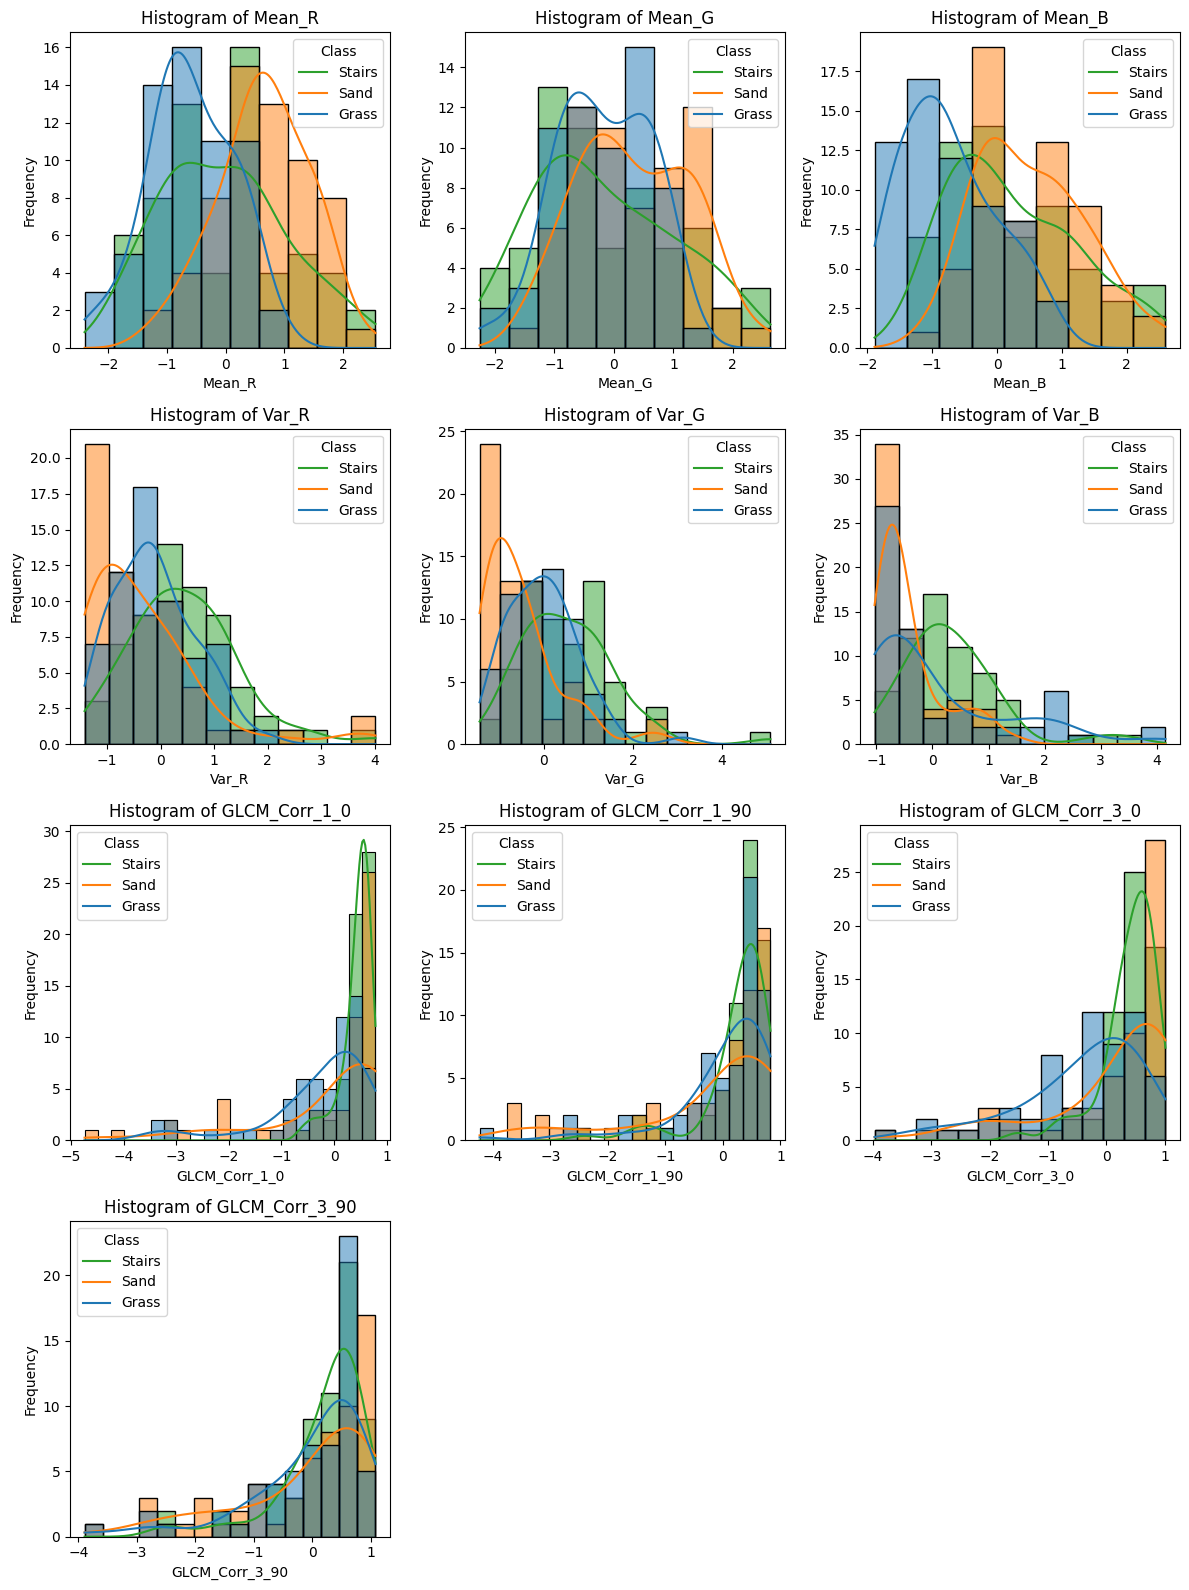

In [ ]:
# Set up the grid layout
num_features = len(feature_names)
num_cols = 3  # Number of columns in the grid
num_rows = -(-num_features // num_cols)  # Ceiling division to get the number of rows

# Make the figure smaller by reducing the figure size
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 4 * num_rows))  # Smaller figure size
axes = axes.flatten()  # Flatten the 2D axes array for easier indexing

# Plot histograms for each feature
for idx, feature in enumerate(feature_names):
    sns.histplot(data=X_scaled_df, x=feature, hue='class', kde=True, multiple='layer',
                 ax=axes[idx])
    axes[idx].set_title(f"Histogram of {feature}")
    axes[idx].set_xlabel(feature)
    axes[idx].set_ylabel("Frequency")
    axes[idx].legend(title="Class", labels=['Stairs', 'Sand', 'Grass'])

# Remove empty subplots if any
for i in range(idx + 1, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


#### Analysis of Features with Discriminative Power for Image Classification



Based on all the histograms above (color statistics and texture features), we can assess which features may be useful for distinguishing Grass, Sand, and Stairs.

Below is a detailed breakdown:

**1. Color-Based Features (Mean and Variance in RGB Channels)**

 **Mean Color Values (Mean_R, Mean_G, Mean_B)**

- Sand is more distinguishable in the Red channel (Mean_R), as it has higher mean red values.
- Grass is more separable in the Green and Blue channels (Mean_G, Mean_B), with higher mean values in both.
- Stairs significantly overlap with both Sand and Grass, making them harder to distinguish using mean color values alone.

**Potentially Discriminative Features:**
- **Mean_R** (for Sand)
- **Mean_G and Mean_B** (for Grass)


**Variance of Color Channels (Var_R, Var_G, Var_B)**

- Sand generally has the lowest variance in all color channels, making it somewhat separable from the other two classes.
- Grass and Stairs have overlapping distributions making it harder to separate them using variance alone.
- Grass tends to have broader variance in green and blue which could help in some cases.

**Potentially Discriminative Features:**
- **Var_R, Var_G, Var_B** (for separating Sand from other classes)


**2. Texture Features (GLCM Correlation Metrics)**

The **Gray-Level Co-occurrence Matrix (GLCM) correlation features** analyze spatial relationships between pixel intensities, helping to identify textural differences.

 **GLCM_Corr_1_0 & GLCM_Corr_1_90**

- Stairs have a strong peak at high correlation values (~1), making them somewhat distinguishable.
- Grass and Sand overlap significantly, reducing their separability.

**GLCM_Corr_3_0 & GLCM_Corr_3_90**

- Stairs and Sand overlap significantly in GLCM_Corr_3_0, making them hard to separate.
- Grass has a broader spread, which might help in differentiating it from Sand.

**Potentially Discriminative Features:**
- **GLCM_Corr_1_0 & GLCM_Corr_1_90** (for identifying Stairs)
- **GLCM_Corr_3_0 & GLCM_Corr_3_90** (for differentiating Grass from Sand to some extent)


<div align="center">

**Overall Summary: Best Features for Discriminating Classes**


| Feature Type             | Discriminates Best Between | Effectiveness |
|--------------------------|--------------------------|--------------|
| **Mean_R**              | Sand vs. Others         | High         |
| **Mean_G & Mean_B**     | Grass vs. Others       | High         |
| **Var_R, Var_G, Var_B** | Sand vs. Others         | Medium       |
| **GLCM_Corr_1_0 & 1_90**| Stairs vs. Others      | High         |
| **GLCM_Corr_3_0 & 3_90**| Grass vs. Sand (partial) | Medium       |


### PCA

- PCA **(1 p)**
    - Plot the image glasses using different colors.
    - Can you see clusters in PCA?
    - Does this figure give you any clues, how well you will be able to classify the image types? Explain.

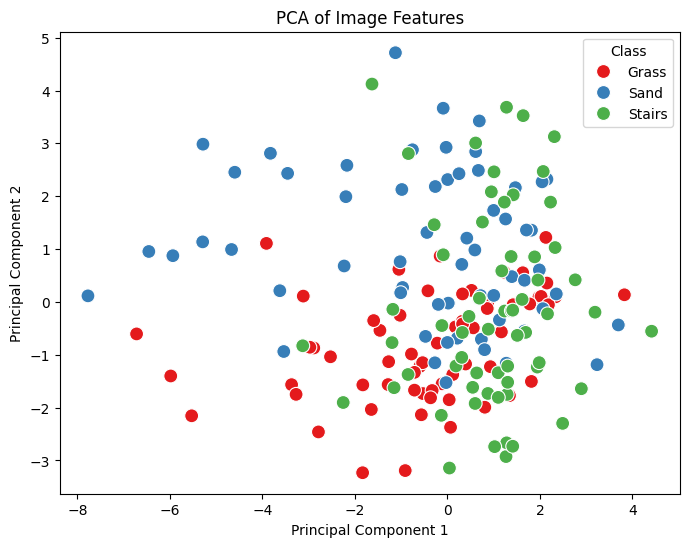

In [ ]:
# Apply PCA to reduce the dimensions to 2
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled_df.drop('class', axis=1))  # Drop the 'class' column from the features

# Create a new DataFrame for the PCA components and add the class labels
pca_df = pd.DataFrame(X_pca, columns=['PCA1', 'PCA2'])
pca_df['class'] = y  # y contains the class labels (Grass, Sand, Stairs)

# Plot the PCA result
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='class', palette='Set1', s=100)

# Customizing the plot
plt.title('PCA of Image Features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title="Class")
plt.show()


**Cluster Observation in PCA**

From the PCA scatter plot, there are **no well-defined, distinct clusters** for the three classes: **Grass (Red), Sand (Blue), and Stairs (Green).** Instead, there is a **significant amount of overlap** among the three categories.

**Implications for Classification**

- **Poor Separability**: Since the points from different classes are interspersed with each other, it suggests that the features used for PCA **do not strongly differentiate** between the three classes.
- **Potential Classification Challenges**: A classifier might struggle to separate these classes effectively, as there is no **clear boundary** between them in the principal component space.

In conclusion, this PCA visualization suggests that **classification accuracy might be low** with simple linear classifiers. More sophisticated techniques or feature engineering may be required for better class separability.


## Build classifiers and select the best hyperparameters with cross validation

Perform model selection for each classifier. Use 5-fold stratified cross validation (*StratifiedKFold* and *GridSearchCV* from sklearn). Use the following hyperparameters:

- Ridge Classifier (1 p)
    - strength of the regularization term: alpha = [0.001, 0.01, 0.1, 1.0]

- Random Forest **(1 p)**
    - n_estimators from 100 to 300 with 50 steps
    - max_features = ['sqrt', 'log2', None]
    - whether to use bootstrap or not
    
- MLP **(1 p)**
    - use one hidden layer
    - number of neurons in the hidden layer from 15 to 40 in 5 neuron steps
    - activation function: hyperbolic tanh function and rectified linear unit function
    - solver: stochastic gradient descent and adam
    - validation_fraction: 0.1 and 0.3
    - strength of the L2 regularization term: alpha = [0.01, 0.1, 1]

For each classifier:
- Report the selected combination of hyperparameters <br>
- Report the accuracy value for each hyperparameter combination <br>

For Random Forest model, report the feature importance for each feature. Which features seem to be the most important? Does this correspond with the observations you made in the data exploration? **(1 p)**

### Ridge Classifier

In [ ]:
# Define the model
ridge_model = RidgeClassifier()

# Hyperparameter grid for alpha
ridge_param_grid = {'alpha': [0.001, 0.01, 0.1, 1.0]}

# Set up StratifiedKFold for 5-fold cross-validation
cv = StratifiedKFold(n_splits=5)

# Set up GridSearchCV with StratifiedKFold
ridge_grid_search = GridSearchCV(ridge_model, ridge_param_grid, cv=cv, scoring='accuracy')

# Fit the model
ridge_grid_search.fit(X_scaled_df.drop('class', axis=1), y)

# Get the best hyperparameters
best_params_ridge = ridge_grid_search.best_params_

# Get the best score
best_score_ridge = ridge_grid_search.best_score_

# Get the results of all hyperparameter combinations
results_ridge = ridge_grid_search.cv_results_


In [ ]:
# Print the results for each alpha
print(f"Ridge Classifier - accuracy value for each hyperparameter combination:")
for mean_score, params in zip(results_ridge['mean_test_score'], results_ridge['params']):
    print(f"Alpha: {params['alpha']}, Mean Cross-Validation Score: {mean_score:.4f}")

# Print the best parameters and best score
print(f"\nBest Hyperparameters: {best_params_ridge}")
print(f"Best Accuracy: {best_score_ridge:.4f}")

Ridge Classifier - accuracy value for each hyperparameter combination:
Alpha: 0.001, Mean Cross-Validation Score: 0.8162
Alpha: 0.01, Mean Cross-Validation Score: 0.8162
Alpha: 0.1, Mean Cross-Validation Score: 0.8162
Alpha: 1.0, Mean Cross-Validation Score: 0.8162

Best Hyperparameters: {'alpha': 0.001}
Best Accuracy: 0.8162


### Random Forest

In [ ]:
# Define the model
rf_model = RandomForestClassifier()

# Hyperparameter grid for Random Forest
rf_param_grid = {
    'n_estimators': [100, 150, 200, 250, 300],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

# Set up StratifiedKFold for 5-fold cross-validation
cv = StratifiedKFold(n_splits=5)

# Set up GridSearchCV with StratifiedKFold
grid_search_rf = GridSearchCV(rf_model, rf_param_grid, cv=cv, scoring='accuracy')

# Fit the model
grid_search_rf.fit(X_scaled_df.drop('class', axis=1), y)

# Get the best hyperparameters
best_params_rf = grid_search_rf.best_params_

# Get the best score
best_score_rf = grid_search_rf.best_score_

# Get the results of all hyperparameter combinations
results_rf = grid_search_rf.cv_results_

In [ ]:
# Print the results for each hyperparameter combination

print(f"Random Forest - accuracy value for each hyperparameter combination:\n")
for mean_score, params in zip(results_rf['mean_test_score'], results_rf['params']):
    print(f"n_estimators: {params['n_estimators']}, max_features: {params['max_features']}, bootstrap: {params['bootstrap']}, Mean Cross-Validation Score: {mean_score:.4f}")

# Print the best parameters and best score
print(f"\nBest Hyperparameters: {best_params_rf}")
print(f"Best Accuracy: {best_score_rf:.4f}")

Random Forest - accuracy value for each hyperparameter combination:

n_estimators: 100, max_features: sqrt, bootstrap: True, Mean Cross-Validation Score: 0.7568
n_estimators: 150, max_features: sqrt, bootstrap: True, Mean Cross-Validation Score: 0.7730
n_estimators: 200, max_features: sqrt, bootstrap: True, Mean Cross-Validation Score: 0.7514
n_estimators: 250, max_features: sqrt, bootstrap: True, Mean Cross-Validation Score: 0.7568
n_estimators: 300, max_features: sqrt, bootstrap: True, Mean Cross-Validation Score: 0.7676
n_estimators: 100, max_features: log2, bootstrap: True, Mean Cross-Validation Score: 0.7459
n_estimators: 150, max_features: log2, bootstrap: True, Mean Cross-Validation Score: 0.7784
n_estimators: 200, max_features: log2, bootstrap: True, Mean Cross-Validation Score: 0.7568
n_estimators: 250, max_features: log2, bootstrap: True, Mean Cross-Validation Score: 0.7730
n_estimators: 300, max_features: log2, bootstrap: True, Mean Cross-Validation Score: 0.7730
n_estimator

### MLP

In [ ]:
# Define the parameter grid for MLP
param_grid_mlp = {
    'hidden_layer_sizes': [(neurons,) for neurons in range(15, 41, 5)],  # Number of neurons in the hidden layer (15 to 40)
    'activation': ['tanh', 'relu'],  # Activation functions
    'solver': ['sgd', 'adam'],  # Solvers
    'validation_fraction': [0.1, 0.3],  # Validation fraction
    'alpha': [0.01, 0.1, 1]  # L2 regularization term
}

# Initialize the MLP classifier
mlp = MLPClassifier(max_iter=2000, random_state=42)

# Set up Stratified K-Fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform grid search using GridSearchCV
grid_search_mlp = GridSearchCV(estimator=mlp, param_grid=param_grid_mlp, cv=cv, n_jobs=-1, verbose=1)
grid_search_mlp.fit(X_scaled_df.drop('class', axis=1), y)  # Using X_scaled_df and y as input data

# Get the best hyperparameters and best score
best_params_mlp = grid_search_mlp.best_params_
best_score_mlp = grid_search_mlp.best_score_

# Get the results of all hyperparameter combinations
results_mlp = grid_search_mlp.cv_results_

Fitting 5 folds for each of 144 candidates, totalling 720 fits


In [ ]:
# Print the results for each hyperparameter combination
print(f"MLP - Combination of hyperparameters:\n")
for mean_score, params in zip(results_mlp['mean_test_score'], results_mlp['params']):
    print(f"activation: {params['activation']}, alpha: {params['alpha']}, hidden_layer_sizes: {params['hidden_layer_sizes']}, solver: {params['solver']}, validation_fraction: {params['validation_fraction']}, Mean Cross-Validation Score: {mean_score:.4f}")

MLP - Combination of hyperparameters:

activation: tanh, alpha: 0.01, hidden_layer_sizes: (15,), solver: sgd, validation_fraction: 0.1, Mean Cross-Validation Score: 0.8108
activation: tanh, alpha: 0.01, hidden_layer_sizes: (15,), solver: sgd, validation_fraction: 0.3, Mean Cross-Validation Score: 0.8108
activation: tanh, alpha: 0.01, hidden_layer_sizes: (15,), solver: adam, validation_fraction: 0.1, Mean Cross-Validation Score: 0.8108
activation: tanh, alpha: 0.01, hidden_layer_sizes: (15,), solver: adam, validation_fraction: 0.3, Mean Cross-Validation Score: 0.8108
activation: tanh, alpha: 0.01, hidden_layer_sizes: (20,), solver: sgd, validation_fraction: 0.1, Mean Cross-Validation Score: 0.7892
activation: tanh, alpha: 0.01, hidden_layer_sizes: (20,), solver: sgd, validation_fraction: 0.3, Mean Cross-Validation Score: 0.7892
activation: tanh, alpha: 0.01, hidden_layer_sizes: (20,), solver: adam, validation_fraction: 0.1, Mean Cross-Validation Score: 0.8216
activation: tanh, alpha: 0.

In [ ]:

# Print the best hyperparameters and the best accuracy
print(f"MLP - Best Hyperparameters: {best_params_mlp}")
print(f"MLP - Best Accuracy: {best_score_mlp:.4f}")

MLP - Best Hyperparameters: {'activation': 'tanh', 'alpha': 0.1, 'hidden_layer_sizes': (25,), 'solver': 'adam', 'validation_fraction': 0.1}
MLP - Best Accuracy: 0.8486


### Feature Importance

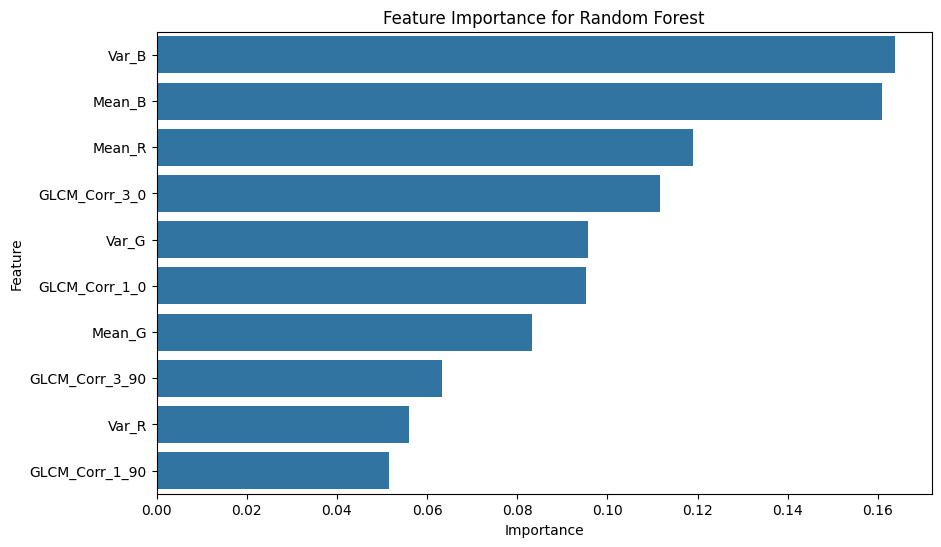

In [ ]:
# Feature Importance
best_rf_model = grid_search_rf.best_estimator_
feature_importances = best_rf_model.feature_importances_

# Get feature names
feature_names = X_scaled_df.drop('class', axis=1).columns

# Create a DataFrame for feature importance
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance for Random Forest')
plt.show()


**Analysis of Feature Importance from Random Forest**

From the feature importance plot, the most important features in classification are:

1. Mean_B (Mean of Blue channel) – The most discriminative feature.
2. Var_B (Variance of Blue channel) – Also highly important.
3. GLCM_Corr_1_0 (GLCM Correlation at 1-pixel distance, 0-degree) – A key texture feature.
4. Mean_R (Mean of Red channel)
5. GLCM_Corr_3_0 (GLCM Correlation at 3-pixel distance, 0-degree)
6. Mean_G (Mean of Green channel)

Yes, the feature importance results from the Random Forest classifier correspond well with the observations from the data exploration.

- The histograms showed significant differences in the Blue channel (Mean_B, Var_B) across classes, then the fact that these features are ranked highest in importance confirms their strong discriminative power.
- The presence of GLCM correlation features among the top-ranked features also aligns with the histogram observations, especially if texture-based histograms indicated variation across classes.
- The Mean_R and Mean_G features being somewhat important suggests that the color channels do contribute but are not as strong as the Blue channel and texture features.

## Estimate the performance of the models with nested cross-validation

Estimate the performance of each model using nested cross validation. <br>
We'll use 4-fold Stratified Kfold cross-validation and the same parameter ranges as earlier for the inner loop. <br>
For the outer loop we'll use 5-fold Stratified Kfold cross-validation.

For each classifier:
- Ridge Classifier **(1 p)**
- Random Forest **(1 p)**
- MLP **(1 p)**

    Report the selected combination of the hyperparameters and the accuracy value for the best hyperparameter combination. <br>
    Create a confusion matrix of the results. <br>
    Calculate the mean accuracy of the outer rounds. What does it mean? **(1 p)**

### Function for nested cv

In [ ]:
# Define 4-fold and 5-fold Stratified KFold
inner_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Function to perform nested cross-validation and return the results
def nested_cv(model, param_grid, X, y, inner_cv, outer_cv):
    outer_accuracies = []
    outer_confusion_matrices = []
    outer_best_params_list = []

    for train_idx, test_idx in outer_cv.split(X, y):
        # Split data for outer loop
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Inner loop for hyperparameter tuning
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=inner_cv, n_jobs=-1)
        grid_search.fit(X_train, y_train)

        # Get the best model from grid search
        best_model = grid_search.best_estimator_
        outer_best_params_list.append(grid_search.best_params_)

        # Evaluate the model on the outer test set
        y_pred = best_model.predict(X_test)

        # Record the accuracy and confusion matrix for this fold
        accuracy = accuracy_score(y_test, y_pred)
        outer_accuracies.append(accuracy)
        outer_confusion_matrices.append(confusion_matrix(y_test, y_pred))

    return outer_accuracies, outer_confusion_matrices, outer_best_params_list

### Ridge Classifier

In [ ]:
ridge_param_grid = {'alpha': [0.001, 0.01, 0.1, 1.0]}
ridge_model = RidgeClassifier()

# Nested CV for Ridge Classifier
ridge_accuracies, ridge_confusion_matrices, ridge_best_params_list = nested_cv(
    ridge_model, ridge_param_grid, X_scaled_df.drop('class', axis=1).values, y, inner_cv, outer_cv
)

In [ ]:
# Print best parameters from each outer fold
print("Ridge Classifier - Selected combination of the hyperparameters for each Fold:")
for i, (params, accuracy) in enumerate(zip(ridge_best_params_list, ridge_accuracies)):
    print(f"Fold {i+1}: {params} - Accuracy: {accuracy:.4f}")


Ridge Classifier - Selected combination of the hyperparameters for each Fold:
Fold 1: {'alpha': 1.0} - Accuracy: 0.8649
Fold 2: {'alpha': 0.001} - Accuracy: 0.8378
Fold 3: {'alpha': 0.001} - Accuracy: 0.7568
Fold 4: {'alpha': 0.001} - Accuracy: 0.8378
Fold 5: {'alpha': 0.001} - Accuracy: 0.8378


**Find best hyperparameters**

In [ ]:
# Find the index of the best accuracy
best_index = np.argmax(ridge_accuracies)

# Get the best accuracy, best parameters, and best confusion matrix
ridge_best_accuracy = ridge_accuracies[best_index]
ridge_best_params = ridge_best_params_list[best_index]
ridge_best_confusion_matrix = ridge_confusion_matrices[best_index]

# Print the results
print(f"Accuracy for the best hyperparameter: {ridge_best_params} - {ridge_best_accuracy:.4f}")

Accuracy for the best hyperparameter: {'alpha': 1.0} - 0.8649


**Confusion Matrix for the best accuracy**

In [ ]:
def plot_confusion_matrix(conf_matrices, model_name, class_labels):

    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrices, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f'Overall Confusion Matrix for {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

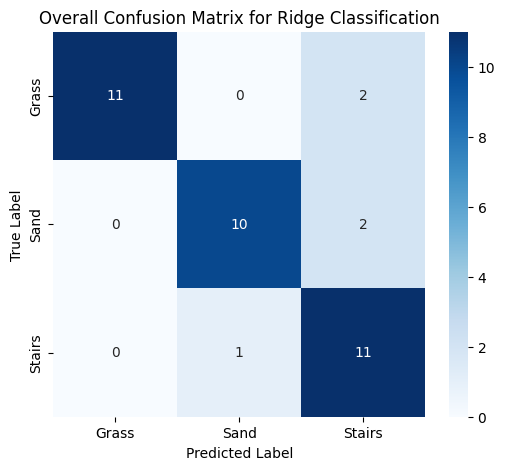

In [ ]:
plot_confusion_matrix(ridge_best_confusion_matrix, 'Ridge Classification', class_names)

#### Mean Accuracy of the Outer Rounds – Ridge Classifier

In [ ]:
ridge_mean_accuracy = np.mean(ridge_accuracies)
print(f"Ridge classifier - Mean Accuracy of the outer rounds: {ridge_mean_accuracy:.4f}")

Ridge classifier - Mean Accuracy of the outer rounds: 0.8270


The mean accuracy of the outer rounds is **0.8270**. This value represents the average classification performance of the Ridge Classifier when evaluated using nested cross-validation. This value gives a reliable estimate of the model's generalization ability, how well it is expected to perform on new, real-world data.

A mean accuracy of **82.7%** suggests that the Ridge Classifier performs fairly well on this dataset. However, the variation in accuracy across folds (ranging from **0.7568** to **0.8649**) suggests that the model's performance depends on the specific training data splits. This variation may indicate that the classifier benefits from certain data distributions but struggles in other cases, pointing to potential areas for further tuning or feature selection.


### Random forest

In [ ]:
rf_param_grid = {
    'n_estimators': [100, 150, 200, 250, 300],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

rf_model = RandomForestClassifier()

# Nested CV for Random Forest
rf_accuracies, rf_confusion_matrices, rf_best_params_list = nested_cv(
    rf_model, rf_param_grid, X_scaled_df.drop('class', axis=1).values, y, inner_cv, outer_cv
)

In [ ]:
# Print best parameters from each outer fold
print("Random forest - Selected combination of the hyperparameters for each Fold:")
for i, (params, accuracy) in enumerate(zip(rf_best_params_list, rf_accuracies)):
    print(f"Fold {i+1}: {params} - Accuracy: {accuracy:.4f}")


Random forest - Selected combination of the hyperparameters for each Fold:
Fold 1: {'bootstrap': True, 'max_features': 'sqrt', 'n_estimators': 250} - Accuracy: 0.7838
Fold 2: {'bootstrap': True, 'max_features': 'sqrt', 'n_estimators': 200} - Accuracy: 0.6486
Fold 3: {'bootstrap': True, 'max_features': None, 'n_estimators': 150} - Accuracy: 0.8108
Fold 4: {'bootstrap': True, 'max_features': None, 'n_estimators': 100} - Accuracy: 0.8108
Fold 5: {'bootstrap': True, 'max_features': None, 'n_estimators': 100} - Accuracy: 0.5946


In [ ]:
# Find the index of the best accuracy
best_index = np.argmax(rf_accuracies)

# Get the best accuracy, best parameters, and best confusion matrix
rf_best_accuracy = rf_accuracies[best_index]
rf_best_params = rf_best_params_list[best_index]
rf_best_confusion_matrix = rf_confusion_matrices[best_index]

# Print the results
print(f"Random Forest - Accuracy for the best hyperparameter: {rf_best_params} - {rf_best_accuracy:.4f}")

Random Forest - Accuracy for the best hyperparameter: {'bootstrap': True, 'max_features': None, 'n_estimators': 150} - 0.8108


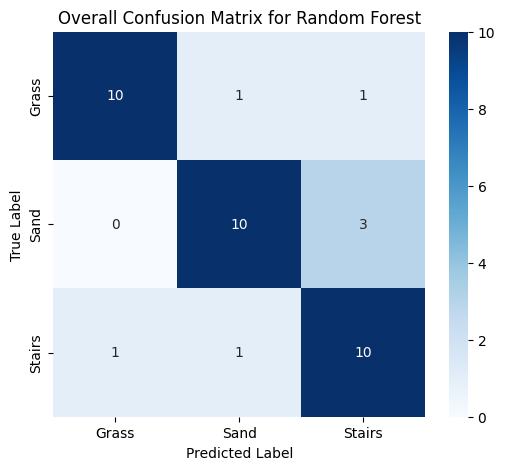

In [ ]:
plot_confusion_matrix(rf_best_confusion_matrix, 'Random Forest', class_names)

#### Mean Accuracy of the Outer Rounds – Random Forest



In [ ]:
rf_mean_accuracy = np.mean(rf_accuracies)
print(f"Random Forest- Mean Accuracy of the Outer Rounds: {rf_mean_accuracy:.4f}")

Random Forest- Mean Accuracy of the Outer Rounds: 0.7297


The mean accuracy of the outer rounds is **0.7297**. This value represents the average classification performance of the Random Forest model across different outer folds in the nested cross-validation process.

A mean accuracy of **72.97%** suggests that the model performs moderately well but has room for improvement. Compared to the Ridge Classifier, its performance is slightly lower, which may indicate that the dataset or the selected hyperparameters do not fully exploit the strengths of Random Forest.

Additionally, the variation between the best accuracy (**0.8108**) and the mean accuracy (**0.7297**) suggests that the model's performance is inconsistent across different data splits. This inconsistency might be due to the complexity of the dataset, class imbalances, or the need for further hyperparameter tuning.


### MLP

In [ ]:
mlp_param_grid = {
    'hidden_layer_sizes': [(neurons,) for neurons in range(15, 41, 5)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'validation_fraction': [0.1, 0.3],
    'alpha': [0.01, 0.1, 1]
}

mlp_model = MLPClassifier(max_iter=2000, random_state=42)

# Nested CV for MLP
mlp_accuracies, mlp_confusion_matrices, mlp_best_params_list = nested_cv(
    mlp_model, mlp_param_grid, X_scaled_df.drop('class', axis=1).values, y, inner_cv, outer_cv
)

In [ ]:
# Find the index of the best accuracy
best_index = np.argmax(mlp_accuracies)

# Get the best accuracy, best parameters, and best confusion matrix
mlp_best_accuracy = mlp_accuracies[best_index]
mlp_best_params = mlp_best_params_list[best_index]
mlp_best_confusion_matrix = mlp_confusion_matrices[best_index]

# Print the results
print(f"MLP - Best hyperparameter: {mlp_best_params} - Accuracy: {mlp_best_accuracy:.4f}")

MLP - Best hyperparameter: {'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (35,), 'solver': 'adam', 'validation_fraction': 0.1} - Accuracy: 0.8649


In [ ]:
# Print best parameters from each outer fold
print("Selected combination of the hyperparameters for each Fold:")
for i, (params, accuracy) in enumerate(zip(mlp_best_params_list, mlp_accuracies)):
    print(f"Fold {i+1}: {params} - Accuracy: {accuracy:.4f}")


Selected combination of the hyperparameters for each Fold:
Fold 1: {'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (35,), 'solver': 'adam', 'validation_fraction': 0.1} - Accuracy: 0.8649
Fold 2: {'activation': 'tanh', 'alpha': 0.1, 'hidden_layer_sizes': (15,), 'solver': 'adam', 'validation_fraction': 0.1} - Accuracy: 0.7568
Fold 3: {'activation': 'tanh', 'alpha': 0.1, 'hidden_layer_sizes': (30,), 'solver': 'adam', 'validation_fraction': 0.1} - Accuracy: 0.8108
Fold 4: {'activation': 'relu', 'alpha': 1, 'hidden_layer_sizes': (25,), 'solver': 'adam', 'validation_fraction': 0.1} - Accuracy: 0.8378
Fold 5: {'activation': 'tanh', 'alpha': 0.1, 'hidden_layer_sizes': (25,), 'solver': 'adam', 'validation_fraction': 0.1} - Accuracy: 0.8649


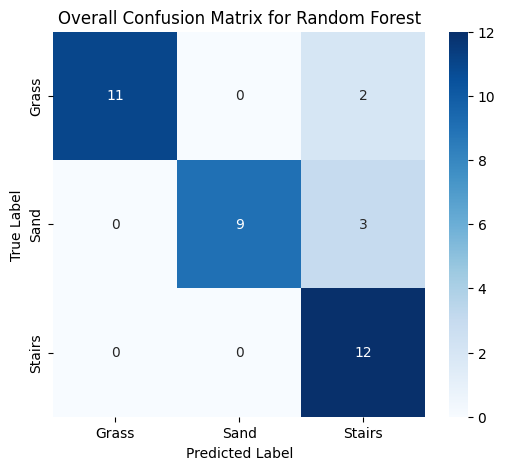

In [ ]:
plot_confusion_matrix(mlp_best_confusion_matrix, 'Random Forest', class_names)

In [ ]:
mlp_mean_accuracy = np.mean(mlp_accuracies)
print(f"MLP - Mean Accuracy of the outer rounds: {mlp_mean_accuracy:.4f}")

MLP - Mean Accuracy of the outer rounds: 0.8270


#### Mean Accuracy of the Outer Rounds – MLP

The mean accuracy of the outer rounds is **0.8270**, indicating that the Multi-Layer Perceptron (MLP) classifier achieved an average classification performance of **82.70%** across different outer folds in the nested cross-validation process.

This suggests that the MLP model performs well on the dataset, showing strong generalization ability.

Additionally, the best accuracy achieved (**0.8649**) is relatively close to the mean accuracy, implying that the model's performance is stable across different training and testing splits. This stability indicates that the chosen hyperparameters and architecture (activation function: **tanh**, hidden layer size: **35**) contribute to consistent performance.


## Discussion

- Discuss you results **(2 p)**
<br>E.g.
    - Which model performs the best and why?
    - What are the limitations?
    - How could the results be improved?

We analyzed three models—**Ridge Classifier, Random Forest, and MLP**—using hyperparameter tuning in one Task and **nested cross-validation** in the next task. Below, we discuss their performance, limitations, and ways to improve the results.


## **1. Which Model Performs the Best and Why?**  

### **First task Results (Hyperparameter Tuning with GridSearchCV)**  
- **Best model:** **MLP** (Best Accuracy: **0.8486**)  
- Ridge classifier performed well (**0.8162**), and Random Forest had the lowest accuracy (**0.7784**).  

### **Second task Results (Nested Cross-Validation for Robust Evaluation)**  
- **Best accuracy in nested CV:** **MLP (0.8649) and Ridge (0.8649)**  
- **Mean accuracy across outer folds:**  
  - **MLP:** 0.8270  
  - **Ridge:** 0.8270  
  - **Random Forest:** 0.7243  

### **Final Verdict: MLP is the Best Model**  
The **MLP model consistently achieved the highest accuracy in both tasks** and had the best generalization ability. The **Ridge classifier was a close second**, while **Random Forest performed the worst.**  

#### **Why Did MLP Perform the Best?**  
- **Captures complex patterns:** Unlike Ridge (which assumes linear relationships), MLP uses **non-linear activation functions (tanh and ReLU)**, allowing it to capture complex patterns in the data.  
- **Efficient optimization:** The best hyperparameters included **adam optimizer**, which is well-suited for training deep learning models.  
- **Optimal regularization:** The selected **alpha = 0.01** prevented overfitting, ensuring a well-generalized model.  

#### **Why Did Ridge Perform Well?**  
- **Simple and robust:** Ridge regression is effective for **high-dimensional data** and **reduces overfitting** with L2 regularization.  
- **Linear relationships in data:** If the dataset had mostly linear patterns, Ridge would naturally perform well.  

#### **Why Did Random Forest Perform the Worst?**  
- **Overfitting risk:** With **only 100 trees** and **log2 max_features**, the model may have struggled with generalization.  
- **Feature importance issue:** Some features may have had weak predictive power, making ensemble learning less effective.  


## **2. What Are the Limitations?**  

### **Limitations of Each Model**  

#### **MLP (Neural Network) Limitations:**  
**Strengths:** Best accuracy, non-linearity, strong generalization  
**Challenges:**  
- **Computationally expensive:** Training takes longer than Ridge or Random Forest.  
- **Sensitive to hyperparameters:** Small changes in **learning rate, neurons, or activation function** can impact performance.  
- **Risk of overfitting:** If not properly regularized, MLP can memorize data rather than generalizing.  

#### **Ridge Classifier Limitations:**  
**Strengths:** Simple, interpretable, avoids overfitting  
**Challenges:**  
- **Assumes linearity:** If data contains complex, **non-linear** relationships, Ridge won't model them well.  
- **Less flexible than MLP:** Cannot capture intricate feature interactions like a neural network can.  

#### **Random Forest Limitations:**  
**Strengths:** Handles missing data, robust to outliers, feature importance analysis  
**Challenges:**  
- **High variance:** Performance varies depending on the selected hyperparameters.  
- **Computational cost:** Training many decision trees is resource-intensive.  
- **Feature selection issue:** Some features might have low importance, reducing predictive power.  

## **3. How Could the Results Be Improved?**  

### **General Improvements for All Models:**  
- **Feature Engineering:**  
  - Remove irrelevant features to improve efficiency.  
  - Create interaction terms to enhance model performance.  

- **More Robust Hyperparameter Tuning:**  
  - Expand hyperparameter ranges (e.g., more values for `alpha`, `n_estimators`, `hidden_layer_sizes`).  
  - Use **Bayesian Optimization** instead of GridSearchCV for better search efficiency.  

- **Data Preprocessing Enhancements:**   
  - Use **PCA or Feature Selection** to remove redundant features.  

### **Final Takeaways**  
- **MLP is the best model**, but requires careful tuning to avoid overfitting.  
- **Ridge Classifier is a strong alternative** if computational efficiency and interpretability are priorities.  
- **Random Forest was the weakest**, but improvements in hyperparameters and feature selection might help.  
